Heavy lift from https://botorch.org/tutorials/closed_loop_botorch_only

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from typing import Optional

import torch

from botorch.models.transforms.input import Normalize
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.objective import GenericMCObjective
from botorch.optim import optimize_acqf
from botorch.utils.transforms import normalize, unnormalize


from gpytorch.kernels import MaternKernel

import time
import warnings

from botorch import fit_gpytorch_mll
from botorch.acquisition import (
    qLogExpectedImprovement,
    qLogNoisyExpectedImprovement,
    qUpperConfidenceBound
)
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.sampling.normal import SobolQMCNormalSampler

import json
import pandas as pd

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

import matplotlib.pyplot as plt

import sys
sys.path.append('/home/bgpelkie/Code/silica-np-synthesis/')
from sample_utilities import samples
import numpy as np

## Load existing data

In [3]:
with open('constants_2024_11_11.json', 'rt') as f:
    synth_constants = json.load(f) 

In [4]:
bounds = {}
for reactant, consts in synth_constants.items():
    bound = (consts['minimum_volume_fraction'], consts['maximum_volume_fraction'])
    bounds[reactant] = bound

In [5]:
synth_data = pd.read_csv('synth_table_ap_distance_11_11_24.csv')
synth_data = synth_data[~synth_data['ap_distance'].isna()]
#synth_data = synth_data[synth_data['ap_distance'] < 6]

In [6]:
synth_data

,uuid,teos_volume,ammonia_volume,water_volume,ethanol_volume,dilution_volume_fraction,silica_mass_conc,silica_mass_fraction,ethanol_dilute_vol,sample_dilute_vol,dilute_well,target_volume,teos_vol_frac,ammonia_vol_frac,water_vol_frac,ethanol_vol_frac,ap_distance,experiment_status
2,130093e4-2947-4d37-b73a-ed4c23442ab8,20.000000,64.000000,49.000000,1567.000000,0.903794,3.190814,0.003982,NaN,NaN,NaN,1700.0,0.011765,0.037647,0.028824,0.921765,0.904308,complete
3,a3f7d49b-cc77-4468-aae0-ad451027ddc0,181.000000,9.000000,228.000000,1283.000000,0.100743,28.625618,0.034357,NaN,NaN,NaN,1701.0,0.106408,0.005291,0.134039,0.754262,1.467659,complete
4,f69628da-ff56-4f3a-ba2e-816036b87557,100.000000,52.000000,15.000000,1534.000000,0.182971,15.761151,0.019630,NaN,NaN,NaN,1701.0,0.058789,0.030570,0.008818,0.901822,1.498439,complete
5,eb5c038c-56ff-4457-93db-9b9702e3ff43,211.000000,12.000000,61.000000,1415.000000,0.086378,33.386217,0.040940,NaN,NaN,NaN,1699.0,0.124191,0.007063,0.035903,0.832843,1.627393,complete
6,56898b1b-5aed-4595-ade6-5b73d45a7808,101.000000,100.000000,33.000000,1467.000000,0.180763,15.953695,0.019736,NaN,NaN,NaN,1701.0,0.059377,0.058789,0.019400,0.862434,1.708555,complete
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,12720234-74cc-4a1a-9cdc-cad646138159,37.738948,9.392500,9.732500,1643.136052,0.723958,5.975150,0.007523,469.0,1231.0,E8,1700.0,0.022199,0.005525,0.005725,0.966551,10.943193,complete
156,86790201-b18a-4f73-907d-61e0d3d0c114,38.236107,14.646381,27.962611,1619.154902,0.714545,6.053864,0.007597,485.0,1215.0,F1,1700.0,0.022492,0.008616,0.016449,0.952444,10.943193,complete
157,8d373b7d-c3a9-4148-8bcd-46021e36cb01,20.613134,27.369475,34.960157,1617.057234,1.325438,3.263646,0.004094,0.0,1700.0,F2,1700.0,0.012125,0.016100,0.020565,0.951210,1.837742,complete
158,be0d7554-70c4-4a1f-a312-eea5e9ae1e45,42.069674,13.507700,38.020931,1606.401695,0.649433,6.660827,0.008343,596.0,1104.0,F3,1700.0,0.024747,0.007946,0.022365,0.944942,10.943193,complete


In [7]:
x_data = synth_data[['teos_vol_frac', 'ammonia_vol_frac', 'water_vol_frac']]
y_data = - synth_data['ap_distance']

In [8]:
y_data.min()

np.float64(-10.943193115906624)

## data pre-processing

In [9]:
y_data_norm = normalize(torch.tensor(y_data.to_numpy()), torch.tensor([[y_data.min()], [y_data.max()]])).reshape(-1,1)

In [10]:
bounds_torch = torch.tensor([bounds['TEOS'], bounds['ammonia'], bounds['water']]).transpose(-1, -2)

In [11]:
x_data_torch = torch.tensor(x_data.to_numpy())

In [12]:
x_data_norm = normalize(x_data_torch, bounds_torch)

## Set up BO things

In [13]:
#bounds = torch.tensor([[0.0] * 3, [1.0] * 3], device=device, dtype=dtype)

BATCH_SIZE = 20  if not SMOKE_TEST else 2
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 32

N_TRIALS = 3 if not SMOKE_TEST else 2
N_BATCH = 20 if not SMOKE_TEST else 2
MC_SAMPLES = 256 if not SMOKE_TEST else 32

## kernal parameters
nu = 5/2
ard_num_dims = 3 # None to turn off

verbose = False

train_x = x_data_norm
train_y = y_data_norm

In [14]:
def initialize_model(train_x, train_y, state_dict=None, nu = 5/2, ard_num_dims = None):
    # define models for objective and constraint
    kernel = MaternKernel(nu = nu, ard_num_dims = 3)
    model_obj = SingleTaskGP(
        train_x,
        train_y,
        input_transform=Normalize(d=train_x.shape[-1]),
        covar_module=kernel
    ).to(train_x)

    # combine into a multi-output GP model
    mll = ExactMarginalLogLikelihood(model_obj.likelihood, model_obj)
    # load state dict if it is passed
    if state_dict is not None:
        model_obj.load_state_dict(state_dict)
    return mll, model_obj

In [15]:
def obj_callable(Z: torch.Tensor, X: Optional[torch.Tensor] = None):
    return Z[..., 0]



objective = GenericMCObjective(objective=obj_callable)

In [16]:
warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)




best_observed_all_ei, best_observed_all_nei, best_random_all = [], [], []

# average over multiple trials


best_observed_ei, best_observed_nei, best_random = [], [], []

# call helper functions to generate initial training data and initialize model

mll_nei, model_nei = initialize_model(train_x, train_y)

t0 = time.monotonic()

# fit the models

fit_gpytorch_mll(mll_nei)

# define the qEI and qNEI acquisition modules using a QMC sampler
qmc_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

# for best_f, we use the best observed noisy values as an approximation


qLogNEI = qLogNoisyExpectedImprovement(
    model=model_nei,
    X_baseline=train_x,
    sampler=qmc_sampler,
    objective=objective,
    prune_baseline=True
)

#ucb = qUpperConfidenceBound(
#    model = model_nei, 
##    beta = 5,
#    sampler = qmc_sampler, 
#)

# optimize for new candidates
candidates, _ = optimize_acqf(
    acq_function=qLogNEI,
    bounds=bounds_torch,
    q=BATCH_SIZE,
    num_restarts=NUM_RESTARTS,
    raw_samples=RAW_SAMPLES,  # used for intialization heuristic
    #options={"batch_limit": 5, "maxiter": 200},
)




In [17]:
posterior = model_nei.posterior(train_x)
mean = posterior.mean.detach()

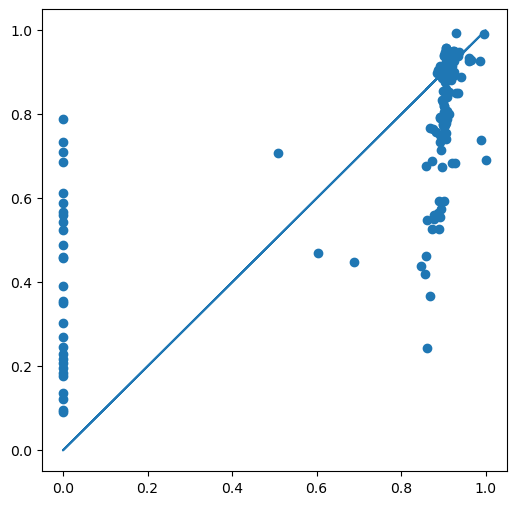

In [18]:
fig, ax = plt.subplots(figsize = (6,6))

ax.scatter(train_y, mean)
ax.plot(train_y, train_y)

(array([29.,  0.,  0.,  0.,  0.,  1.,  2.,  0., 35., 72.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

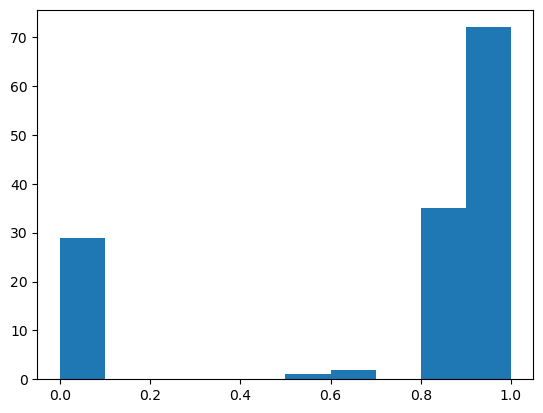

In [19]:
plt.hist(train_y)

## Visualize new batch

In [20]:
from sklearn.manifold import TSNE

In [21]:
tsne = TSNE()

In [22]:
x_data_norm.shape

torch.Size([139, 3])

In [23]:
all_x = torch.cat([x_data_norm, candidates])

In [24]:
x_tsne_og = tsne.fit_transform(all_x)

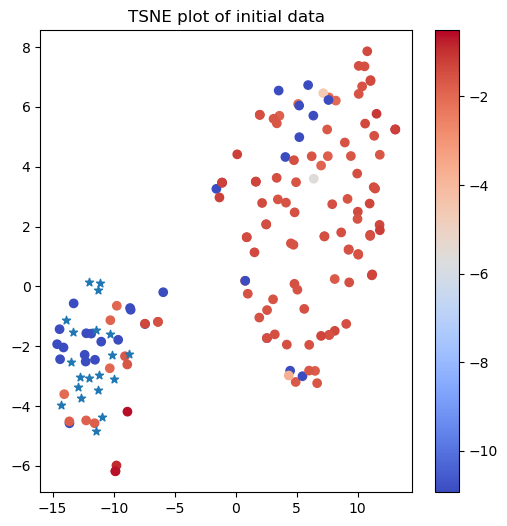

In [25]:
fig, ax = plt.subplots(figsize = (6,6))

sc = ax.scatter(x_tsne_og[:,0][:len(x_data_norm)], x_tsne_og[:,1][:len(x_data_norm)], c = y_data, cmap = plt.cm.coolwarm)
ax.scatter(x_tsne_og[:,0][len(x_data_norm):], x_tsne_og[:,1][len(x_data_norm):], marker='*')
ax.set_title("TSNE plot of initial data")
fig.colorbar(sc, ax = ax)

## Prep new sample table for next experiment

In [26]:
x_fractions = unnormalize(candidates, bounds_torch)

In [27]:
target_volume = 1700
target_dilution = 0.1 # mol Si/L saxs sample
constants_fp = './constants_2024_11_11.json'
samples_write_fp = 'Sample_table_2024_11_11_optimizationRound2.csv'


In [28]:
samples_gen = []
for row in x_fractions:
    teos_vf = float(row[0])
    ammonia_vf = float(row[1])
    water_vf = float(row[2])

    sample = samples.SolidSilicaSample(target_volume, teos_vol_frac = teos_vf, ammonia_vol_frac=ammonia_vf, water_vol_frac=water_vf, reactant_fp = constants_fp)
    sample.calculate_reactant_volumes()
    sample.calculate_dilution_volumefraction(target_dilution)
    sample.calculate_silica_mass_concentration()
    sample.calculate_silica_mass_fraction()
    samples_gen.append(sample)

In [29]:
synth_table = samples.generate_synthesis_table(samples_gen)

In [30]:
synth_table['ethanol_dilute_vol'] = np.round(target_volume*(1-synth_table['dilution_volume_fraction']))
synth_table['sample_dilute_vol'] = np.round(target_volume * synth_table['dilution_volume_fraction'])

In [31]:
synth_table.loc[synth_table['ethanol_dilute_vol'] < 0, 'ethanol_dilute_vol'] = 0
synth_table.loc[synth_table['sample_dilute_vol'] > target_volume, 'sample_dilute_vol'] = target_volume

In [32]:
#assign rows to sample table
rows = ['A', 'B', 'C', 'D', 'E', 'F']
cols = [1, 2, 3, 4, 5, 6, 7, 8]

wells = []

#skip [B,E]x[2,7]
for row in rows:
    for col in cols:
        if row in ['B', 'E'] and col in [2, 7]:
            pass
        else:
            wells.append(row + str(col))

In [33]:
synth_table['well'] = wells[:len(synth_table)]


In [34]:
synth_table['dilute_well'] = wells[len(synth_table):2*len(synth_table)]

## Visualize new batch

In [35]:
synth_data['rank'] = synth_data['ap_distance'].rank()

In [36]:
best_row = synth_data.iloc[synth_data['ap_distance'].argmin()]

In [37]:
best10 = synth_data.iloc[synth_data['rank'].argsort().iloc[:10]]

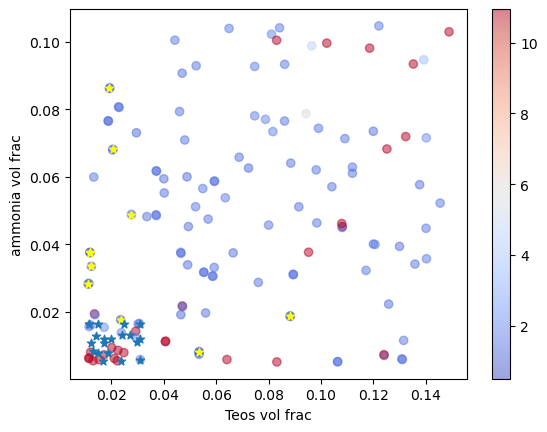

In [38]:
fig, ax = plt.subplots()

sc = ax.scatter(synth_data['teos_vol_frac'], synth_data['ammonia_vol_frac'], c = synth_data['ap_distance'], cmap = plt.cm.coolwarm, alpha=0.5)
ax.set_xlabel('Teos vol frac')
ax.set_ylabel('ammonia vol frac')


ax.scatter(best10['teos_vol_frac'], best10['ammonia_vol_frac'], marker = '*', color = 'yellow')
cbar = fig.colorbar(sc, ax = ax)

ax.scatter(synth_table['teos_volume']/1700, synth_table['ammonia_volume']/target_volume, marker = '*')

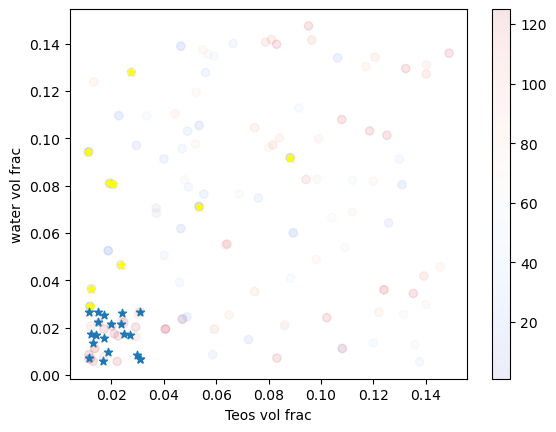

In [39]:
fig, ax = plt.subplots()

sc = ax.scatter(synth_data['teos_vol_frac'], synth_data['water_vol_frac'], c = synth_data['rank'], cmap = plt.cm.coolwarm, alpha=0.1)
ax.set_xlabel('Teos vol frac')
ax.set_ylabel('water vol frac')
cbar = fig.colorbar(sc, ax = ax)

ax.scatter(best10['teos_vol_frac'], best10['water_vol_frac'], marker = '*', color = 'yellow')

ax.scatter(synth_table['teos_volume']/1700, synth_table['water_volume']/target_volume, marker = '*')

In [40]:
synth_table

,uuid,teos_volume,ammonia_volume,water_volume,ethanol_volume,dilution_volume_fraction,silica_mass_conc,silica_mass_fraction,ethanol_dilute_vol,sample_dilute_vol,well,dilute_well
0,131f3c99-0c3f-430d-880c-effef7248f1f,52.700002,20.530716,11.336403,1615.432879,0.720046,8.343911,0.010476,476.0,1224.0,A1,C7
1,3988b456-0f05-4af3-af65-7da9eab0ee6c,52.700002,9.814073,11.267935,1626.217990,0.720046,8.343911,0.010485,476.0,1224.0,A2,C8
2,9184744f-b57b-466e-ac26-2628b429fdda,25.406110,28.135001,45.475003,1600.983886,1.493595,4.022510,0.005035,0.0,1700.0,A3,D1
3,37300e48-9860-4742-8c2b-0ca12c5d51d1,50.655813,18.661142,14.006110,1616.676934,0.749103,8.020257,0.010069,427.0,1273.0,A4,D2
4,3af12ee2-596f-48b6-8c5b-565269a55562,20.762388,18.558863,29.378120,1631.300628,1.827652,3.287277,0.004130,0.0,1700.0,A5,D3
5,13a21dba-b25c-4ec6-945b-e13b30d2d50f,29.382918,18.112973,43.007904,1609.496206,1.291445,4.652152,0.005828,0.0,1700.0,A6,D4
6,0799ec06-5d0f-4589-a10c-b9a98c310f5c,22.213458,14.129779,23.280026,1640.376738,1.708263,3.517023,0.004424,0.0,1700.0,A7,D5
7,02bb1532-f5b4-4970-a885-68b4b420114e,46.285829,22.488408,28.822210,1602.403553,0.819828,7.328365,0.009181,306.0,1394.0,A8,D6
8,4d0ecb5c-939e-4cf3-ad18-c4651703d936,28.818030,9.392500,9.994820,1651.794650,1.316760,4.562715,0.005750,0.0,1700.0,B1,D7
9,9cabbf21-c7c6-4d8c-b88f-27e18a59fa8d,19.379999,28.135001,11.893371,1640.591629,1.958020,3.068406,0.003863,0.0,1700.0,B3,D8


In [41]:
synth_table.to_csv('SampleTable_2024_11_11_OptimizationRound2.csv')